In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import (f1_score, confusion_matrix, classification_report, log_loss, 
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay , accuracy_score)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import chi2, SelectKBest

In [3]:
# Load csv file
dfTrain = pd.read_csv('train_data.csv', sep='|')

In [ ]:
# Remove age values that is equal to -1
dfTrain = dfTrain[dfTrain.age != -1]
# Remove label values that is equal to NaN
dfTrain = dfTrain.loc[dfTrain['label'].notnull()]

In [4]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41907133 entries, 0 to 41907132
Data columns (total 36 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   label                        int64 
 1   uid                          int64 
 2   task_id                      int64 
 3   adv_id                       int64 
 4   creat_type_cd                int64 
 5   adv_prim_id                  int64 
 6   dev_id                       int64 
 7   inter_type_cd                int64 
 8   slot_id                      int64 
 9   spread_app_id                int64 
 10  tags                         int64 
 11  app_first_class              int64 
 12  app_second_class             int64 
 13  age                          int64 
 14  city                         int64 
 15  city_rank                    int64 
 16  device_name                  int64 
 17  device_size                  int64 
 18  career                       int64 
 19  gender             

In [11]:
# Group trainData by age
userSubsetGroup = dfTrain.groupby(['age'])

# Take 50,000 rows for every age group ranging from 1 to 7. Set replace=False to remove permission of any repeating rows
userAge1 = userSubsetGroup.get_group(1).sample(n=50000, replace=False)
userAge2 = userSubsetGroup.get_group(2).sample(n=50000, replace=False)
userAge3 = userSubsetGroup.get_group(3).sample(n=50000, replace=False)
userAge4 = userSubsetGroup.get_group(4).sample(n=50000, replace=False)
userAge5 = userSubsetGroup.get_group(5).sample(n=50000, replace=False)
userAge6 = userSubsetGroup.get_group(6).sample(n=50000, replace=False)
userAge7 = userSubsetGroup.get_group(7).sample(n=50000, replace=False)

# Append every age groups into one and convert it into a csv file
userAgeGroup = userAge1.append([userAge2, userAge3, userAge4, userAge5, userAge6, userAge7])
userAgeGroup.to_csv('ageGroup.csv', index=False)

In [481]:
# Load csv file
ageGroup = pd.read_csv('ageGroup.csv', sep=',')
ageGroup = ageGroup.drop('communication_onlinerate', axis=1)
ageGroup = ageGroup.drop('uid', axis=1)
ageGroup[ageGroup < 0] = 0
ageGroup.head()

,label,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,emui_dev,list_time,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_avgonline_30d,indu_name,pt_d
0,0,2521,1925,7,207,17,5,21,13,37,...,14,13,2,0,0,0,2,11,17,1
1,0,3456,3720,7,107,15,5,21,46,39,...,14,10,3,14,0,0,2,12,36,1
2,0,3854,3367,7,207,17,5,17,13,37,...,27,17,4,11,0,0,5,13,17,1
3,0,3401,1766,7,156,56,5,14,58,37,...,20,14,5,14,0,0,2,11,17,1
4,0,3219,6128,4,143,60,3,17,78,23,...,12,9,4,0,0,0,2,11,37,1


In [482]:
# Features variable
x = ageGroup.drop(['label'], axis=1)
# Target variable
y = ageGroup["label"]
y = LabelEncoder().fit_transform(y)

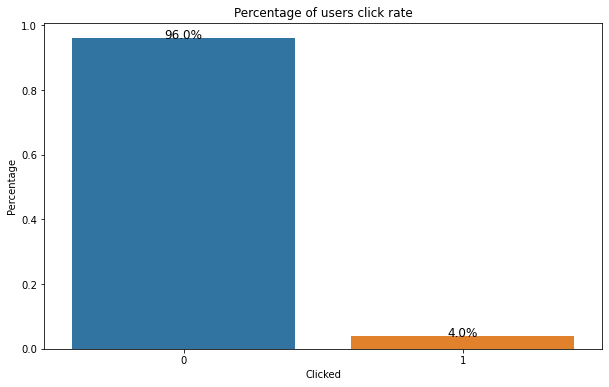

In [382]:
# Initializing a figure and subplot axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bar graph in seaborn
barGraph = sns.barplot(ageGroup['label'], ageGroup['label'], estimator=lambda x: (len(x) / len(ageGroup)))

# Annotate bars with values
for p in barGraph.patches:
    width, height = p.get_width(), p.get_height()
    x_graph, y_graph = p.get_xy() 
    barGraph.text(x_graph+width/2, 
           y_graph+height, 
           '{0:.1%}'.format(height), 
           horizontalalignment='center',fontsize=12)

# Set the xy labels and the title
ax.set_xlabel('Clicked')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of users click rate')

# Display the data visualization 
plt.show() 

In [483]:
# Train test split with stratifiedKfold, train: 80% test: 20%

cv = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in cv.split(x, y):
    x_train, y_train = x.iloc[train_idx], y[train_idx]
    x_test, y_test = x.iloc[test_idx], y[test_idx]

In [484]:
# Select 10 features with k highest score
select_feature = SelectKBest(chi2, k=10).fit(x_train, y_train)

# Transform x train and x test data with the selected feature
x_train = pd.DataFrame(select_feature.transform(x_train), columns = x_train.columns[select_feature.get_support()])
x_test = pd.DataFrame(select_feature.transform(x_test), columns = x_test.columns[select_feature.get_support()])

print(x_train.columns)

# Oversample
over = SMOTE()

# Resample the train and test data with oversampling method
x_train_oversample, y_train_oversample = over.fit_resample(x_train, y_train)  
x_test_oversample, y_test_oversample = over.fit_resample(x_test, y_test)  

Index(['task_id', 'adv_id', 'adv_prim_id', 'dev_id', 'slot_id', 'tags',
       'device_size', 'career', 'up_life_duration', 'indu_name'],
      dtype='object')


Text(0, 0.5, '')

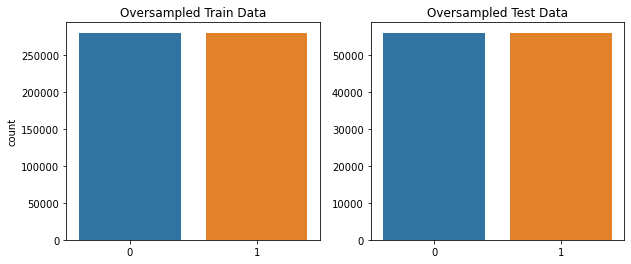

In [497]:
# Show graph to visualize the oversampled train and test data 
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
sns.countplot(y_train_oversample, ax=axs[0])
sns.countplot(y_test_oversample, ax=axs[1])
axs[0].set_title('Oversampled Train Data')
axs[1].set_title('Oversampled Test Data')
axs[1].set_ylabel('')

In [22]:
# Function for printing ROC and f1 score
def print_results(ytest, ypred, ypredproba):
    roc = roc_auc_score(ytest, ypredproba[:,1], average='weighted')
    f1 = f1_score(ytest, ypred, average='weighted')
    print('[ Metrics Evaluation ]\n')
    print('ROC Auc:    {}'.format(roc))
    print('f1 Score:     {}'.format(f1))
    print(('Classification Report:\n{}'.format(classification_report(ytest, ypred))))
    return roc, f1

### LightGBM Classifier

In [21]:
paramGrid = dict(max_depth= range(15, 20, 1))

gridSearch = GridSearchCV(lgbm, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.9283309595037931 using {'max_depth': 19}


In [550]:
paramGrid = dict(num_leaves=range(200, 250, 1))

gridSearch = GridSearchCV(lgbm, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.9281324598623865 using {'num_leaves': 248}


In [402]:
# LightGBM (oversample train & test data)

lgbm_params = {
    'max_depth': 19, 
    'num_leaves': 248, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = lgbm.predict(x_test_oversample)
y_predproba_oversample = lgbm.predict_proba(x_test_oversample)      

roc_lgbm_oversample, f1_lgbm_oversample = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.9457535279931729
f1 Score:     0.8700541417777424
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     67228
           1       0.87      0.87      0.87     67228

    accuracy                           0.87    134456
   macro avg       0.87      0.87      0.87    134456
weighted avg       0.87      0.87      0.87    134456

[58501  8727  8745 58483]


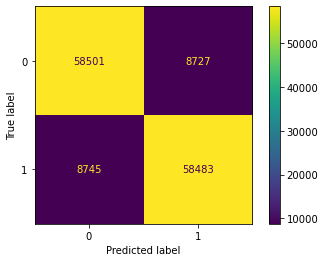

In [403]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

In [404]:
# LightGBM Classifier (oversample train data)

lgbm_params = {
    'max_depth': 19, 
    'num_leaves': 248, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)


y_pred = lgbm.predict(x_test)
y_predproba = lgbm.predict_proba(x_test)      

roc_lgbm, f1_lgbm = print_results(y_test,y_pred, y_predproba) 
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6634217808133439
f1 Score:     0.8867589379005262
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     67228
           1       0.10      0.34      0.15      2772

    accuracy                           0.85     70000
   macro avg       0.53      0.60      0.53     70000
weighted avg       0.93      0.85      0.89     70000

[58501  8727  1842   930]


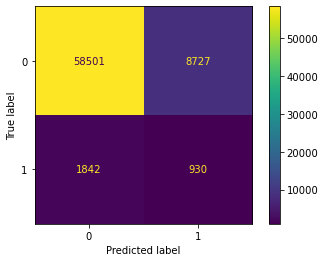

In [405]:
cm = confusion_matrix(y_test, y_pred, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

### XGBoost Classifier

In [406]:
# xgboost classifier (oversample train & test set)

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = xgbc.predict(x_test_oversample)
y_predproba_oversample = xgbc.predict_proba(x_test_oversample)      

roc_xgb_oversample, f1_xgb_oversample = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.9468783487779138
f1 Score:     0.8714165555880183
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87     67228
           1       0.86      0.89      0.87     67228

    accuracy                           0.87    134456
   macro avg       0.87      0.87      0.87    134456
weighted avg       0.87      0.87      0.87    134456

[57464  9764  7520 59708]


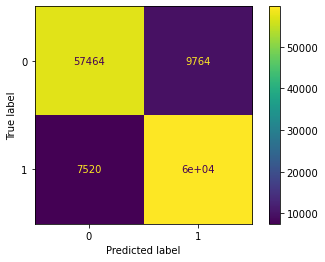

In [408]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

In [410]:
# xgboost classifier

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred = xgbc.predict(x_test)
y_predproba = xgbc.predict_proba(x_test)      

roc_xgb, f1_xgb = print_results(y_test,y_pred, y_predproba)
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6658512033225694
f1 Score:     0.8788899940155706
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     67228
           1       0.09      0.37      0.15      2772

    accuracy                           0.84     70000
   macro avg       0.53      0.61      0.53     70000
weighted avg       0.94      0.84      0.88     70000

[57464  9764  1752  1020]


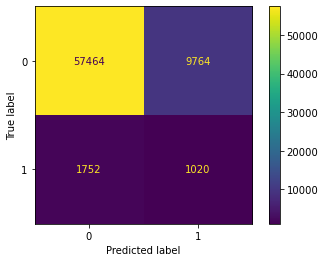

In [411]:
cm = confusion_matrix(y_test, y_pred, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

### Decision Tree Classifier

In [93]:
paramGrid = dict(min_samples_split=range(15, 25, 1))

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score: 0.906109302155284 using {'min_samples_split': 19}


In [33]:
paramGrid = dict(criterion=['gini', 'entropy'])

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.8935200220895334 using {'criterion': 'entropy'}


In [240]:
paramGrid = dict(min_samples_leaf=range(1, 90, 1))

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 89 candidates, totalling 445 fits
Best score: 0.905753419628024 using {'min_samples_leaf': 4}


In [218]:
paramGrid = dict(max_depth=range(30, 50, 1))

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score: 0.9062097046676609 using {'max_depth': 46}


In [493]:
# Decision Tree Classifier (oversample train & test set)

dtc_params =  {
    'min_samples_split': 19,
    'criterion': 'entropy',
    'min_samples_leaf': 4,
    'max_depth': 46
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = dtc.predict(x_test_oversample)
y_predproba_oversample = dtc.predict_proba(x_test_oversample)         

roc_dtc_oversample, f1_dtc_oversample = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.8312878597993554
f1 Score:     0.7689703754748289
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79     67228
           1       0.82      0.70      0.75     67228

    accuracy                           0.77    134456
   macro avg       0.78      0.77      0.77    134456
weighted avg       0.78      0.77      0.77    134456

[56714 10514 20382 46846]


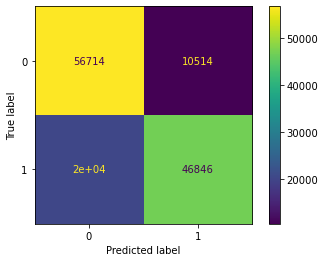

In [494]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

In [442]:
# Decision Tree Classifier (oversample train set)

dtc_params =  {
    'min_samples_split': 19,
    'criterion': 'entropy',
    'min_samples_leaf': 4,
    'max_depth': 46
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)
y_pred = dtc.predict(x_test)
y_predproba = dtc.predict_proba(x_test)      

roc_dtc, f1_dtc = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.6078879605367825
f1 Score:     0.8720961343207491
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90     67228
           1       0.08      0.32      0.13      2772

    accuracy                           0.83     70000
   macro avg       0.52      0.58      0.51     70000
weighted avg       0.93      0.83      0.87     70000

[56876 10352  1888   884]


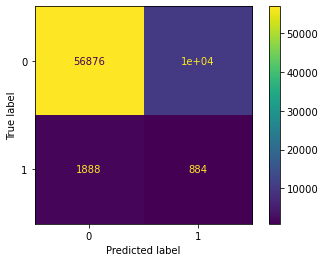

In [443]:
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

### Random Forest Classifier

In [162]:
paramGrid = dict(min_samples_split=range(2, 5, 1))

gridSearch = GridSearchCV(rfc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score: 0.9453383022202295 using {'min_samples_split': 3}


In [176]:
paramGrid = dict(max_leaf_nodes=range(-20, -15, 1))

gridSearch = GridSearchCV(rfc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.9392118181916238 using {'max_leaf_nodes': -18}


In [485]:
# Random Forest Classifier (oversample train & test set)

rfc_params =  {
    'min_samples_split': 3,
    'max_leaf_nodes':-18
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = rfc.predict(x_test_oversample)
y_predproba_oversample = rfc.predict_proba(x_test_oversample)      

roc_rfc_oversample, f1_rfc_oversample = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.8702136830844958
f1 Score:     0.7854569689749235
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80     67228
           1       0.85      0.70      0.77     67228

    accuracy                           0.79    134456
   macro avg       0.80      0.79      0.79    134456
weighted avg       0.80      0.79      0.79    134456

[58794  8434 20192 47036]


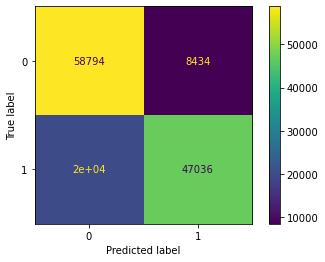

In [486]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

In [487]:
# Random Forest Classifier (oversample train set)

rfc_params =  {
    'min_samples_split': 3,
    'max_leaf_nodes':-18
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred = rfc.predict(x_test)
y_predproba = rfc.predict_proba(x_test)      

roc_rfc, f1_rfc = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.6053896430153347
f1 Score:     0.8873442757158836
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     67228
           1       0.08      0.28      0.13      2772

    accuracy                           0.85     70000
   macro avg       0.53      0.58      0.52     70000
weighted avg       0.93      0.85      0.89     70000

[58815  8413  2005   767]


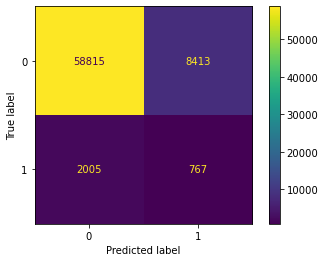

In [488]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

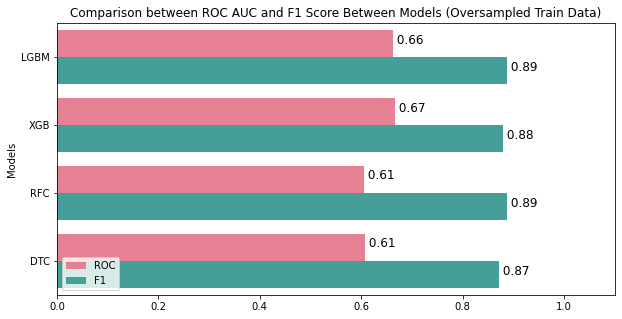

In [495]:
# Plot the comparison between ROC AUC and F1 Score for Oversampled Tuned Train Data

labelArr = np.array(['ROC', 'ROC', 'ROC', 'ROC', 'F1', 'F1', 'F1', 'F1'])
metricsArr = np.array([roc_lgbm, roc_xgb, roc_rfc, roc_dtc, f1_lgbm, f1_xgb, f1_rfc, f1_dtc])
xArr = np.array(['LGBM', 'XGB', 'RFC', 'DTC', 'LGBM', 'XGB', 'RFC', 'DTC'])

# Plot ROC and F1 from all models
plt.figure(figsize=(10, 5))
bar = sns.barplot(metricsArr, xArr, hue=labelArr, palette='husl')
plt.legend(loc='lower left')
bar.set(xlim = (None, 1.1))
bar.set_title('Comparison between ROC AUC and F1 Score Between Models (Oversampled Train Data)')
bar.set_ylabel("Models")

# Put the exact value in the graph
for p in bar.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)

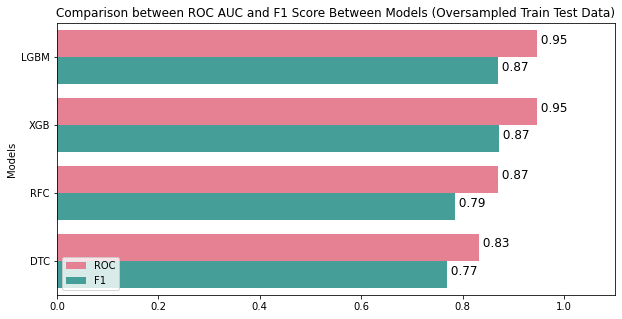

In [496]:
# Plot the comparison between ROC AUC and F1 Score for Oversampled Tuned Train Test Data

labelArr = np.array(['ROC', 'ROC', 'ROC', 'ROC', 'F1', 'F1', 'F1', 'F1'])
metricsArr = np.array([roc_lgbm_oversample, roc_xgb_oversample, roc_rfc_oversample, roc_dtc_oversample, f1_lgbm_oversample, f1_xgb_oversample, f1_rfc_oversample, f1_dtc_oversample])
xArr = np.array(['LGBM', 'XGB', 'RFC', 'DTC', 'LGBM', 'XGB', 'RFC', 'DTC'])

# Plot ROC and F1 from all models
plt.figure(figsize=(10, 5))
bar = sns.barplot(metricsArr, xArr, hue=labelArr, palette='husl')
plt.legend(loc='lower left')
bar.set(xlim = (None, 1.1))
bar.set_title('Comparison between ROC AUC and F1 Score Between Models (Oversampled Train Test Data)')
bar.set_ylabel("Models")

# Put the exact value in the graph
for p in bar.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)

## Comparing Metrics Evaluation with new added features

### Adding Age Column

In [615]:
# Features variable
x = ageGroup.loc[:, ['task_id', 'adv_id', 'adv_prim_id', 'dev_id', 'slot_id', 'tags',
       'device_size', 'career', 'up_life_duration', 'indu_name', 'age']]

# Target variable
y = ageGroup["label"]
y = LabelEncoder().fit_transform(y)

In [616]:
# Train test split with stratifiedKfold, train: 80% test: 20%

cv = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in cv.split(x, y):
    x_train, y_train = x.iloc[train_idx], y[train_idx]
    x_test, y_test = x.iloc[test_idx], y[test_idx]

# Oversample
over = SMOTE()

# Resample the train and test data with oversampling method
x_train_oversample, y_train_oversample = over.fit_resample(x_train, y_train)  
x_test_oversample, y_test_oversample = over.fit_resample(x_test, y_test)  

### LightGBM Classifier

In [153]:
paramGrid = dict(max_depth= range(15, 20, 1))

gridSearch = GridSearchCV(lgbm, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.56210080943397 using {'max_depth': 17}


In [154]:
paramGrid = dict(num_leaves=range(200, 250, 1))

gridSearch = GridSearchCV(lgbm, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.61634375829999 using {'num_leaves': 242}


In [499]:
# LightGBM (oversample train & test data)

lgbm_params = {
    'max_depth': 16, 
    'num_leaves': 242, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = lgbm.predict(x_test_oversample)
y_predproba_oversample = lgbm.predict_proba(x_test_oversample)      

roc_lgbm_oversample_1, f1_lgbm_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.946784035426233
f1 Score:     0.8754061439410294
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     67228
           1       0.88      0.87      0.87     67228

    accuracy                           0.88    134456
   macro avg       0.88      0.88      0.88    134456
weighted avg       0.88      0.88      0.88    134456

[59177  8051  8701 58527]


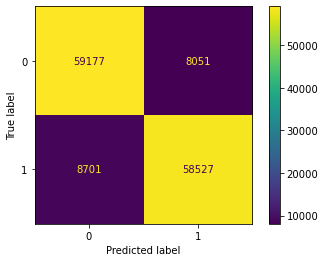

In [500]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

In [541]:
# LightGBM Classifier (oversample train data)

lgbm_params = {
      'max_depth': 16, 
    'num_leaves': 242, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)


y_pred = lgbm.predict(x_test)
y_predproba = lgbm.predict_proba(x_test)      

roc_lgbm_1, f1_lgbm_1 = print_results(y_test,y_pred, y_predproba) 
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6634868042038418
f1 Score:     0.8927113131207702
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     67228
           1       0.10      0.30      0.15      2772

    accuracy                           0.86     70000
   macro avg       0.53      0.59      0.53     70000
weighted avg       0.93      0.86      0.89     70000

[59340  7888  1938   834]


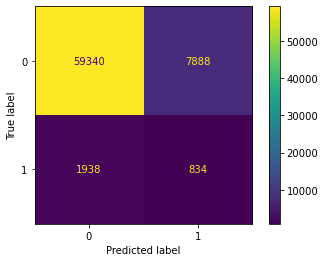

In [542]:
cm = confusion_matrix(y_test, y_pred, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

### XGBoost Classifier

In [543]:
# xgboost classifier (oversample train & test set)

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = xgbc.predict(x_test_oversample)
y_predproba_oversample = xgbc.predict_proba(x_test_oversample)      

roc_xgb_oversample_1, f1_xgb_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.9473590268434458
f1 Score:     0.8740259621381931
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     67228
           1       0.87      0.88      0.87     67228

    accuracy                           0.87    134456
   macro avg       0.87      0.87      0.87    134456
weighted avg       0.87      0.87      0.87    134456

[58252  8976  7961 59267]


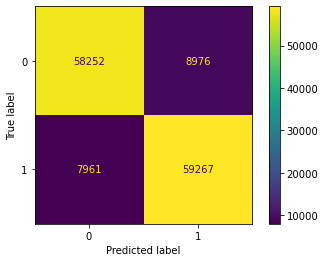

In [544]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

In [545]:
# xgboost classifier (oversample train set)

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred = xgbc.predict(x_test)
y_predproba = xgbc.predict_proba(x_test)      

roc_xgb_1, f1_xgb_1 = print_results(y_test,y_pred, y_predproba)
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6635768737404217
f1 Score:     0.8845960210632788
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     67228
           1       0.09      0.34      0.15      2772

    accuracy                           0.85     70000
   macro avg       0.53      0.60      0.53     70000
weighted avg       0.93      0.85      0.88     70000

[58252  8976  1843   929]


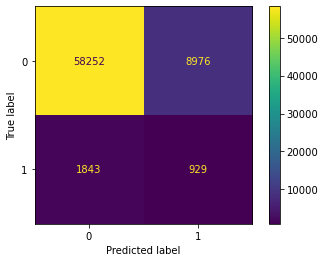

In [546]:
cm = confusion_matrix(y_test, y_pred, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

### Decision Tree  Classifier

In [165]:
paramGrid = dict(max_depth=range(30, 50, 1))

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score: 0.6447835366148288 using {'max_depth': 48}


In [224]:
paramGrid = dict(min_samples_leaf=range(1, 10, 1))

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: 0.6559546925174393 using {'min_samples_leaf': 2}


In [619]:
# Decision Tree Classifier (oversample train & test set)

dtc_params =  {
    'min_samples_split': 19,
    'criterion': 'entropy',
    'min_samples_leaf': 2,
    'max_depth': 48,
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = dtc.predict(x_test_oversample)
y_predproba_oversample = dtc.predict_proba(x_test_oversample)         

roc_dtc_oversample_1, f1_dtc_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.8200397796180012
f1 Score:     0.7689080756332759
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79     67228
           1       0.83      0.68      0.75     67228

    accuracy                           0.77    134456
   macro avg       0.78      0.77      0.77    134456
weighted avg       0.78      0.77      0.77    134456

[58246  8982 21807 45421]


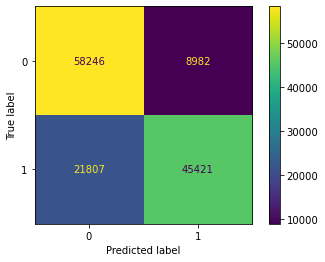

In [620]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

In [617]:
# Decision Tree Classifier (oversample train set)

dtc_params =  {
    'min_samples_split': 19,
    'criterion': 'entropy',
    'min_samples_leaf': 2,
    'max_depth': 48,
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)
y_pred = dtc.predict(x_test)
y_predproba = dtc.predict_proba(x_test)      

roc_dtc_1, f1_dtc_1 = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.5933977038873808
f1 Score:     0.8819939965910115
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.91     67228
           1       0.07      0.26      0.12      2772

    accuracy                           0.84     70000
   macro avg       0.52      0.56      0.51     70000
weighted avg       0.93      0.84      0.88     70000

[58257  8971  2050   722]


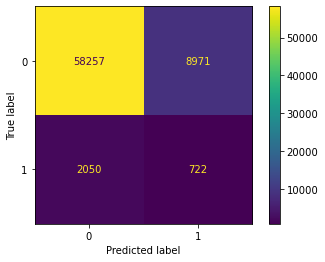

In [618]:
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

### Random Forest Classifier

In [594]:
# Random Forest Classifier (oversample train & test set)

rfc_params =  {
    'min_samples_split': 2,
    'max_leaf_nodes':-22,
    'max_depth': 41
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = rfc.predict(x_test_oversample)
y_predproba_oversample = rfc.predict_proba(x_test_oversample)      

roc_rfc_oversample_1, f1_rfc_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.8780456942795721
f1 Score:     0.7885043623223835
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81     67228
           1       0.87      0.68      0.77     67228

    accuracy                           0.79    134456
   macro avg       0.81      0.79      0.79    134456
weighted avg       0.81      0.79      0.79    134456

[60529  6699 21398 45830]


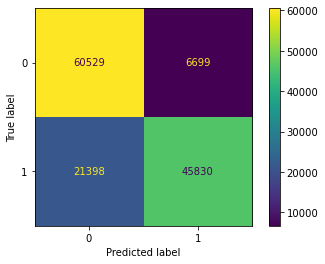

In [595]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

In [596]:
# Random Forest Classifier (oversample train set)

rfc_params =  {
    'min_samples_split': 2,
    'max_leaf_nodes':-22,
    'max_depth': 41
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred = rfc.predict(x_test)
y_predproba = rfc.predict_proba(x_test)      

roc_rfc_1, f1_rfc_1 = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.6000622888396584
f1 Score:     0.8999725751260677
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     67228
           1       0.09      0.23      0.13      2772

    accuracy                           0.87     70000
   macro avg       0.53      0.56      0.53     70000
weighted avg       0.93      0.87      0.90     70000

[60522  6706  2138   634]


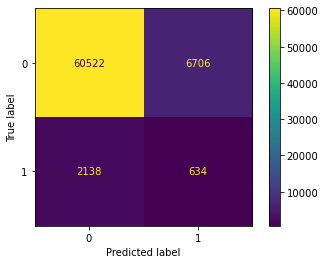

In [597]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

### Adding Age and Gender Column

In [634]:
# Features variable
x = ageGroup.loc[:, ['task_id', 'adv_id', 'adv_prim_id', 'dev_id', 'slot_id', 'tags',
       'device_size', 'career', 'up_life_duration', 'indu_name', 'age', 'gender']]

# Target variable
y = ageGroup["label"]
y = LabelEncoder().fit_transform(y)

In [635]:
# Train test split with stratifiedKfold, train: 70% test: 30%

cv = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in cv.split(x, y):
    x_train, y_train = x.iloc[train_idx], y[train_idx]
    x_test, y_test = x.iloc[test_idx], y[test_idx]

# Oversample
over = SMOTE()

# Resample the train and test data with oversampling method
x_train_oversample, y_train_oversample = over.fit_resample(x_train, y_train)  
x_test_oversample, y_test_oversample = over.fit_resample(x_test, y_test)  

### LightGBM Classifier

In [186]:
paramGrid = dict(max_depth= range(15, 20, 1))

gridSearch = GridSearchCV(lgbm, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.5995918621009773 using {'max_depth': 19}


In [187]:
paramGrid = dict(num_leaves=range(200, 250, 1))

gridSearch = GridSearchCV(lgbm, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.638011673585485 using {'num_leaves': 234}


In [623]:
# LightGBM (oversample train & test data)

lgbm_params = {
    'max_depth': 19, 
    'num_leaves': 234, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = lgbm.predict(x_test_oversample)
y_predproba_oversample = lgbm.predict_proba(x_test_oversample)      

roc_lgbm_oversample_2, f1_lgbm_oversample_2 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.9557464116971184
f1 Score:     0.8892901763959735
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     67228
           1       0.90      0.88      0.89     67228

    accuracy                           0.89    134456
   macro avg       0.89      0.89      0.89    134456
weighted avg       0.89      0.89      0.89    134456

[60483  6745  8139 59089]


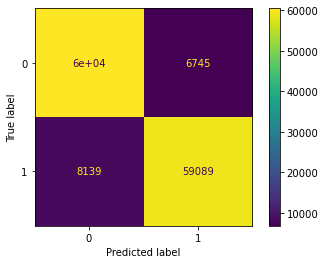

In [624]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

In [625]:
# LightGBM Classifier (oversample train data)

lgbm_params = {
    'max_depth': 19, 
    'num_leaves': 234, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)


y_pred = lgbm.predict(x_test)
y_predproba = lgbm.predict_proba(x_test)      

roc_lgbm_2, f1_lgbm_2 = print_results(y_test,y_pred, y_predproba) 
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6585274606857876
f1 Score:     0.9012140490341148
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     67228
           1       0.10      0.27      0.15      2772

    accuracy                           0.87     70000
   macro avg       0.53      0.58      0.54     70000
weighted avg       0.93      0.87      0.90     70000

[60483  6745  2027   745]


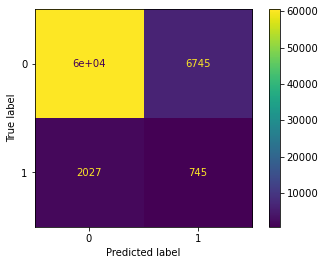

In [626]:
cm = confusion_matrix(y_test, y_pred, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

### XGBoost Classifier

In [628]:
# xgboost classifier (oversample train & test set)

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = xgbc.predict(x_test_oversample)
y_predproba_oversample = xgbc.predict_proba(x_test_oversample)      

roc_xgb_oversample_2, f1_xgb_oversample_2 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.9546570048558485
f1 Score:     0.8868397375259427
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     67228
           1       0.89      0.89      0.89     67228

    accuracy                           0.89    134456
   macro avg       0.89      0.89      0.89    134456
weighted avg       0.89      0.89      0.89    134456

[59470  7758  7457 59771]


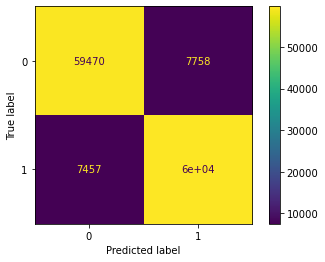

In [629]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

In [630]:
# xgboost classifier

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred = xgbc.predict(x_test)
y_predproba = xgbc.predict_proba(x_test)      

roc_xgb_2, f1_xgb_2 = print_results(y_test,y_pred, y_predproba)
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6590283728752819
f1 Score:     0.8938218512405345
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     67228
           1       0.10      0.30      0.15      2772

    accuracy                           0.86     70000
   macro avg       0.53      0.59      0.54     70000
weighted avg       0.93      0.86      0.89     70000

[59470  7758  1938   834]


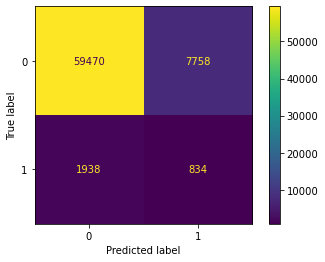

In [631]:
cm = confusion_matrix(y_test, y_pred, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

### Decision Tree Classifier

In [204]:
paramGrid = dict(min_samples_split=range(2, 10, 1))

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best score: 0.6736592324646221 using {'min_samples_split': 4}


In [103]:
paramGrid = dict(criterion=['gini', 'entropy'])

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.6686519800110352 using {'criterion': 'entropy'}


In [104]:
paramGrid = dict(min_samples_leaf=range(1, 90, 1))

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 89 candidates, totalling 445 fits
Best score: 0.6666759074468757 using {'min_samples_leaf': 2}


In [105]:
paramGrid = dict(max_depth=range(30, 50, 1))

gridSearch = GridSearchCV(dtc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score: 0.6667909645727985 using {'max_depth': 48}


In [636]:
# Decision Tree Classifier (oversample train & test set)

dtc_params =  {
    'min_samples_split': 19,
    'criterion': 'entropy',
    'min_samples_leaf': 2,
    'max_depth': 48
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = dtc.predict(x_test_oversample)
y_predproba_oversample = dtc.predict_proba(x_test_oversample)         

roc_dtc_oversample_2, f1_dtc_oversample_2 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.8407288166068667
f1 Score:     0.7898647922355475
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81     67228
           1       0.85      0.71      0.77     67228

    accuracy                           0.79    134456
   macro avg       0.80      0.79      0.79    134456
weighted avg       0.80      0.79      0.79    134456

[58827  8401 19655 47573]


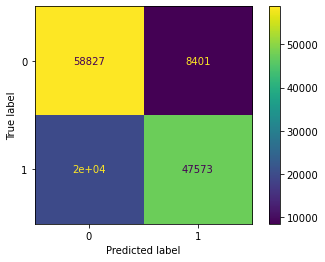

In [637]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

In [638]:
# Decision Tree Classifier

dtc_params =  {
    'min_samples_split': 4,
    'criterion': 'entropy',
    'min_samples_leaf': 2,
    'max_depth': 48
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)
y_pred = dtc.predict(x_test)
y_predproba = dtc.predict_proba(x_test)      

roc_dtc_2, f1_dtc_2 = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.5731313176388144
f1 Score:     0.8918465210224881
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     67228
           1       0.07      0.22      0.11      2772

    accuracy                           0.86     70000
   macro avg       0.52      0.55      0.52     70000
weighted avg       0.93      0.86      0.89     70000

[59612  7616  2173   599]


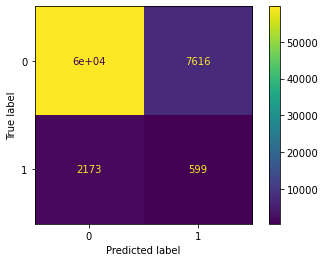

In [639]:
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

### Random Forest Classifier

In [246]:
paramGrid = dict(min_samples_split=range(2, 5, 1))

gridSearch = GridSearchCV(rfc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score: 0.7851194349109762 using {'min_samples_split': 2}


In [10]:
paramGrid = dict(max_leaf_nodes=range(-25, -20, 1))

gridSearch = GridSearchCV(rfc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.7944248631008209 using {'max_leaf_nodes': -22}


In [14]:
paramGrid = dict(max_depth=range(30, 50, 1))

gridSearch = GridSearchCV(rfc, 
                           paramGrid, 
                           cv=5,
                           scoring="roc_auc", 
                           n_jobs=-1,
                           verbose=1)
               
gridSearchResult = gridSearch.fit(x_train_oversample, y_train_oversample)
print(f'Best score: {gridSearchResult.best_score_} using {gridSearchResult.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score: 0.7960349842291814 using {'max_depth': 41}


In [640]:
# Random Forest Classifier (oversample train & test set)

rfc_params =  {
    'min_samples_split': 2,
    'max_leaf_nodes':-22,
    'max_depth': 41
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = rfc.predict(x_test_oversample)
y_predproba_oversample = rfc.predict_proba(x_test_oversample)      

roc_rfc_oversample_2, f1_rfc_oversample_2 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.8935911275185742
f1 Score:     0.8092919151300325
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     67228
           1       0.89      0.71      0.79     67228

    accuracy                           0.81    134456
   macro avg       0.83      0.81      0.81    134456
weighted avg       0.83      0.81      0.81    134456

[61661  5567 19788 47440]


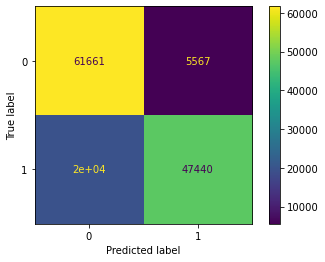

In [641]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

In [642]:
# Random Forest Classifier

rfc_params =  {
    'min_samples_split': 2,
    'max_leaf_nodes':-22,
    'max_depth': 41
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred = rfc.predict(x_test)
y_predproba = rfc.predict_proba(x_test)      

roc_rfc_2, f1_rfc_2 = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.5966871952231476
f1 Score:     0.9089187544497084
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     67228
           1       0.09      0.21      0.13      2772

    accuracy                           0.89     70000
   macro avg       0.53      0.56      0.54     70000
weighted avg       0.93      0.89      0.91     70000

[61687  5541  2192   580]


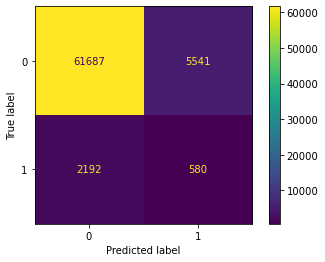

In [643]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

## Plot the comparison of the metrics evaluations 

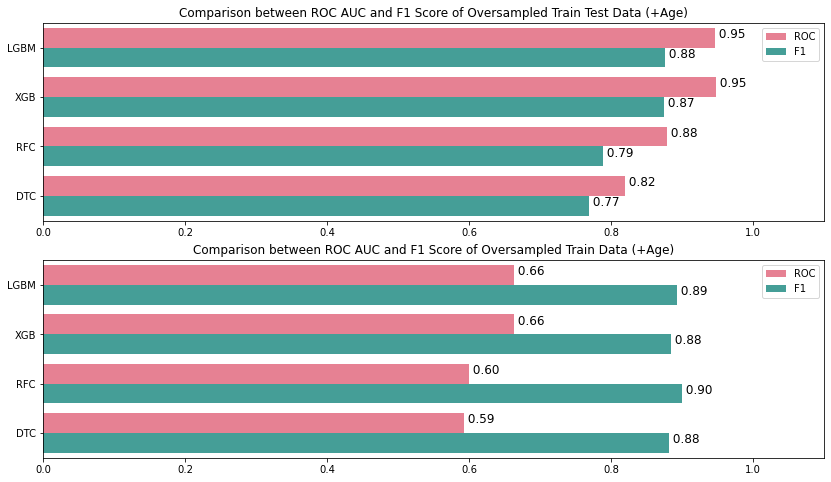

<Figure size 720x360 with 0 Axes>

In [646]:
# Plot the comparison between ROC AUC and F1 Score for Oversampled Train Test Data

fig, axs = plt.subplots(nrows=2, figsize=(14,8))

labelArr = np.array(['ROC', 'ROC', 'ROC', 'ROC', 'F1', 'F1', 'F1', 'F1'])
metricsArr = np.array([roc_lgbm_oversample_1, roc_xgb_oversample_1, roc_rfc_oversample_1, roc_dtc_oversample_1, f1_lgbm_oversample_1, f1_xgb_oversample_1, f1_rfc_oversample_1, f1_dtc_oversample_1])
xArr = np.array(['LGBM', 'XGB', 'RFC', 'DTC', 'LGBM', 'XGB', 'RFC', 'DTC'])

metricsArr2 = np.array([roc_lgbm_1, roc_xgb_1, roc_rfc_1, roc_dtc_1, f1_lgbm_1, f1_xgb_1, f1_rfc_1, f1_dtc_1])

# Plot ROC and F1 from all models
plt.figure(figsize=(10, 5))
bar = sns.barplot(metricsArr, xArr, hue=labelArr, palette='husl', ax=axs[0])
bar2 = sns.barplot(metricsArr2, xArr, hue=labelArr, palette='husl', ax=axs[1])
axs[0].set(xlim = (None, 1.1))
axs[1].set(xlim = (None, 1.1))
axs[0].set_title('Comparison between ROC AUC and F1 Score of Oversampled Train Test Data (+Age)')
axs[1].set_title('Comparison between ROC AUC and F1 Score of Oversampled Train Data (+Age)')
# Put the exact value in the graph
for p in bar.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)
    
for p in bar2.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar2.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)

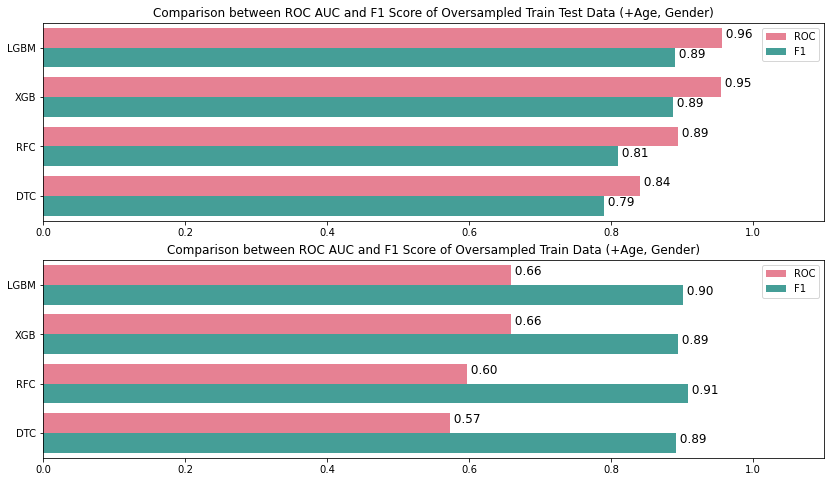

<Figure size 720x360 with 0 Axes>

In [647]:
# Plot the comparison between ROC AUC and F1 Score for Oversampled Train Test Data

fig, axs = plt.subplots(nrows=2, figsize=(14,8))

labelArr = np.array(['ROC', 'ROC', 'ROC', 'ROC', 'F1', 'F1', 'F1', 'F1'])
metricsArr = np.array([roc_lgbm_oversample_2, roc_xgb_oversample_2, roc_rfc_oversample_2, roc_dtc_oversample_2, f1_lgbm_oversample_2, f1_xgb_oversample_2, f1_rfc_oversample_2, f1_dtc_oversample_2])
xArr = np.array(['LGBM', 'XGB', 'RFC', 'DTC', 'LGBM', 'XGB', 'RFC', 'DTC'])

metricsArr2 = np.array([roc_lgbm_2, roc_xgb_2, roc_rfc_2, roc_dtc_2, f1_lgbm_2, f1_xgb_2, f1_rfc_2, f1_dtc_2])

# Plot ROC and F1 from all models
plt.figure(figsize=(10, 5))
bar = sns.barplot(metricsArr, xArr, hue=labelArr, palette='husl', ax=axs[0])
bar2 = sns.barplot(metricsArr2, xArr, hue=labelArr, palette='husl', ax=axs[1])
axs[0].set(xlim = (None, 1.1))
axs[1].set(xlim = (None, 1.1))
axs[0].set_title('Comparison between ROC AUC and F1 Score of Oversampled Train Test Data (+Age, Gender)')
axs[1].set_title('Comparison between ROC AUC and F1 Score of Oversampled Train Data (+Age, Gender)')
# Put the exact value in the graph
for p in bar.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)
    
for p in bar2.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar2.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)